## Data description and preprocessing


1. Load dataset

In [1]:
import os
import pandas as pd
dataset_path = '/Users/huxiyan/Desktop/H/25Spring/COSC410/TrashType_Image_Dataset'
garbage_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

dat = []
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    for file in os.listdir(folder_path):
        dat.append((os.path.join(dataset_path, garbage_type, file), garbage_type))
        
df = pd.DataFrame(dat, columns=['filepath', 'label'])

2. Split

In [2]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"Number of images in the data set: {len(df)}")
print(f"Number of images in the training set: {len(train_set)}")
print(f"Number of images in the test set: {len(test_set)}")

Number of images in the data set: 2527
Number of images in the training set: 2021
Number of images in the test set: 506


3. With/without Augmentation

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator()

train_generator = datagen.flow_from_dataframe(
    train_set,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    test_set,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


## Model training

In [4]:
from tensorflow import keras
from tensorflow.keras import layers, Input

model = keras.Sequential([
    Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(garbage_types), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, epochs=30, validation_data=test_generator)


Epoch 1/30


/Users/huxiyan/Desktop/H/25Spring/COSC410/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.1969 - loss: 39.2749 - val_accuracy: 0.3123 - val_loss: 1.6520
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.3009 - loss: 1.6947 - val_accuracy: 0.2984 - val_loss: 1.6576
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.3256 - loss: 1.6619 - val_accuracy: 0.2866 - val_loss: 1.7177
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.3210 - loss: 1.6689 - val_accuracy: 0.2668 - val_loss: 1.7369
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.3544 - loss: 1.5634 - val_accuracy: 0.3142 - val_loss: 1.6667
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.4086 - loss: 1.4193 - val_accuracy: 0.3162 - val_loss: 1.7482
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.4433 - loss: 1.3845 - val_accuracy: 0.3202 - val_loss: 1.7110
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.4847 - loss: 1.2802 - val_accuracy: 0.3261 - val

## Model evaluation

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Classification Report:
               precision    recall  f1-score   support

   cardboard       0.59      0.78      0.67        81
       glass       0.36      0.27      0.31       100
       metal       0.39      0.37      0.38        82
       paper       0.38      0.47      0.42       119
     plastic       0.43      0.36      0.39        97
       trash       0.22      0.15      0.18        27

    accuracy                           0.42       506
   macro avg       0.40      0.40      0.39       506
weighted avg       0.41      0.42      0.41       506



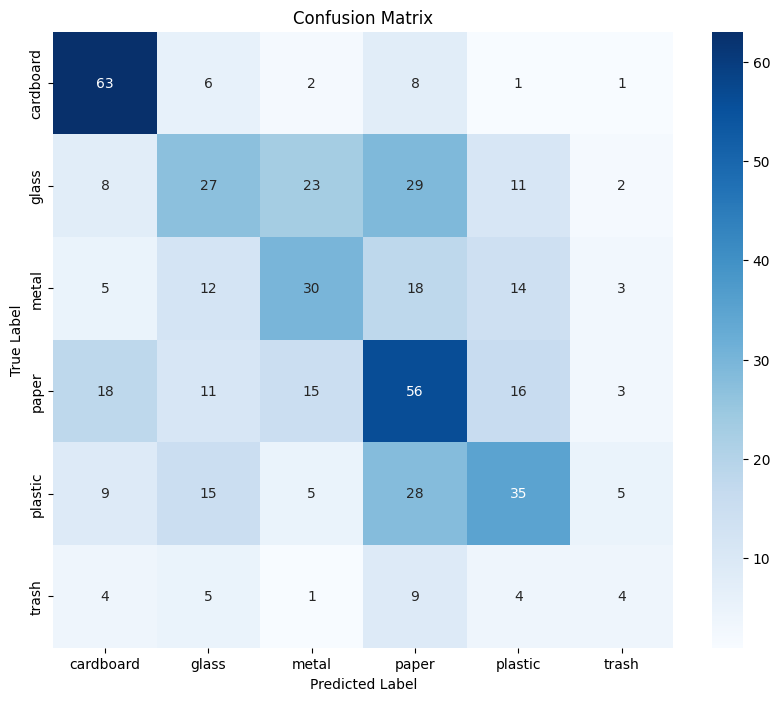

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true = test_set['label'].tolist()  
y_pred = model.predict(test_generator)

y_pred_labels = np.argmax(y_pred, axis=1)
class_labels = list(train_generator.class_indices.keys()) 
y_true_labels = [class_labels.index(label) for label in y_true] 

report = classification_report(y_true_labels, y_pred_labels, target_names=class_labels)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()